In [1]:
import os

import sys
sys.path.append("/data/Lautaro/Documentos/BrainAgeCOVID/pyment-public-main/keras-explainability")
from explainability import LRP, LRPStrategy

from pyment.models import BinarySFCN, RegressionSFCN
from pyment.postprocessing import get_postprocessing


IMAGE_FOLDER = os.path.join('/data/Lautaro/Documentos/BrainAgeCOVID/DATOS/Preprocessed/pyment/prueba_explainability')
#LABELS_FILE = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'IXI.xls')
MODEL = RegressionSFCN
WEIGHTS = 'brain-age-2022'
LRP_STRATEGY = LRPStrategy(
    layers=[
        {'flat': True},
        {'flat': True},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'epsilon': 0.25},
    ]
)

model = MODEL(weights=WEIGHTS)
explainer = LRP(model, layer=-1, idx=0, strategy=LRP_STRATEGY)

2025-09-15 11:08:48.696352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 11:08:48.737246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757945328.754939  763665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757945328.759278  763665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-15 11:08:48.783218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from tensorflow.keras import Model
from tqdm import tqdm

# Crear carpeta para guardar los gráficos si no existe
output_folder = os.path.join(os.getcwd(), 'brainage_explainability')
os.makedirs(output_folder, exist_ok=True)


for imageid in tqdm(os.listdir(IMAGE_FOLDER)):

    path = os.path.join(IMAGE_FOLDER, imageid, 'mri', 'cropped.nii.gz')
    subjectid = imageid[0:18]

    if not os.path.isfile(path):
        print(f'Skipping {imageid}: Missing cropped.nii.gz')
        continue

    img = nib.load(path).get_fdata()
    batch = np.expand_dims(img, 0)

    prediction = model.predict(batch, verbose=0)[0]
    prediction = model.postprocess(prediction)

    explanation = explainer.predict(batch, verbose=0)[0, ..., 0]
    explanation[img == 0] = 0
    explanation = explanation / np.amax(np.abs(explanation))
    # Coordenadas del voxel más representativo

    height, width, depth = np.unravel_index(np.argmax(np.abs(explanation)), explanation.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Explicabilidad - Sujeto {subjectid} - Predicción: {prediction:.2f}')

# Sagittal View (YZ)
    img_sag = np.rot90(img[height, :, :])
    exp_sag = np.rot90(explanation[height, :, :])
    ax[0].imshow(img_sag, cmap='gray')
    im0 = ax[0].imshow(exp_sag, cmap='seismic', clim=(-0.5, 0.5), alpha=0.6)
    ax[0].set_title('Sagittal View')

# Coronal View (XZ)
    img_cor = np.rot90(img[:, width, :])
    exp_cor = np.rot90(explanation[:, width, :])
    ax[1].imshow(img_cor, cmap='gray')
    im1 = ax[1].imshow(exp_cor, cmap='seismic', clim=(-0.5, 0.5), alpha=0.6)
    ax[1].set_title('Coronal View')

# Axial View (XY)
    img_axi = np.rot90(img[:, :, depth])
    exp_axi = np.rot90(explanation[:, :, depth])
    ax[2].imshow(img_axi, cmap='gray')
    im2 = ax[2].imshow(exp_axi, cmap='seismic', clim=(-0.5, 0.5), alpha=0.6)
    ax[2].set_title('Axial View')

# Colorbar
    cbar = fig.colorbar(im2, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Correlación', rotation=270, labelpad=15)

# Guardar gráfico
    #output_path = os.path.join(output_folder, f'{subjectid}_explanation_overlay.png')
    #plt.savefig(output_path)
    #plt.close()
    plt.show()




In [8]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from tensorflow.keras import Model
from tqdm import tqdm

# Crear la carpeta 'brainage_explainability' si no existe
output_folder = os.path.join(os.getcwd(), 'brainage_explainability')
os.makedirs(output_folder, exist_ok=True)

# Inicializar variables para acumular explicaciones y contar imágenes procesadas
explanation_sum = None
image_count = 0

IMAGE_FOLDER = os.path.join('/data/Lautaro/Documentos/BrainAgeCOVID/DATOS/Preprocessed/pyment/freesurfer+fsl(CogConVar)')
for imageid in tqdm(os.listdir(IMAGE_FOLDER)):
    
    path = os.path.join(IMAGE_FOLDER, imageid, 'mri', 'cropped.nii.gz')
    subjectid = imageid[0:6]
    
    if not os.path.isfile(path):
        print(f'Skipping {imageid}: Missing cropped.nii.gz')
        continue
    
    # Obtener la edad del sujeto desde el DataFrame 'labels'
    #subject_row = labels[labels['ID'] == subjectid]
    #if subject_row.empty:
    #    print(f'Skipping {imageid}: Subject ID {subjectid} not found in labels')
    #    continue
    #age = subject_row['Edad'].values[0]  # Extraer la edad del sujeto
    
    img = nib.load(path)
    affine=img.affine
    img = img.get_fdata()
    
    # Adds an extra dimension to fake the image being part of a batch
    batch = np.expand_dims(img, 0)
    
    prediction = model.predict(batch, verbose=0)[0]
    prediction = model.postprocess(prediction)
    
    explanation = explainer.predict(batch, verbose=0)[0,...,0]
    explanation[img == 0] = 0  # Ignorar valores fuera del cerebro
    explanation = explanation / np.amax(np.abs(explanation))  # Normalización estándar
    
    # Acumular las explicaciones
    if explanation_sum is None:
        explanation_sum = explanation
    else:
        explanation_sum += explanation
    image_count += 1

# Calcular el promedio de las explicaciones
if image_count > 0:
    explanation_avg_cn = explanation_sum / image_count
else:
    raise ValueError("No se procesaron imágenes válidas.")



100%|██████████| 158/158 [05:49<00:00,  2.21s/it]


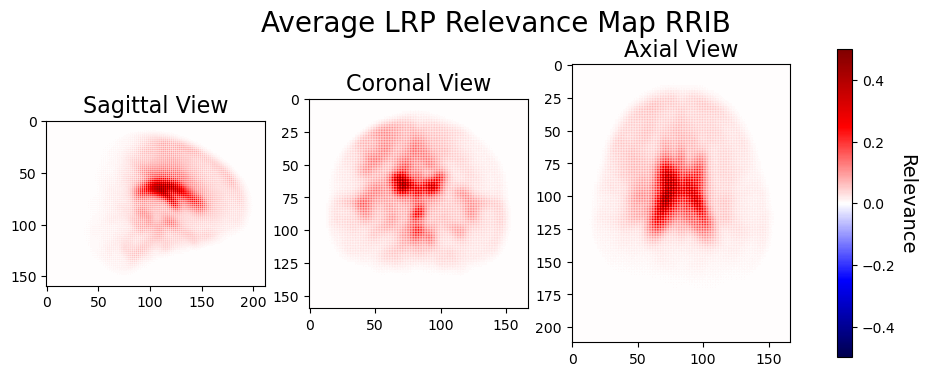

Coordenadas del voxel más representativo: (Height: 71, Width: 109, Depth: 93)


In [9]:
# Graficar el promedio de las explicaciones
height, width, depth = np.unravel_index(np.argmax(np.abs(explanation_avg_cn)), explanation_avg_cn.shape)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Average LRP Relevance Map RRIB', fontsize=20)

# Sagittal View → fijamos eje X en "height"
im0 = ax[0].imshow(np.rot90(explanation_avg_cn[height, :, :]), cmap='seismic', clim=(-0.5, 0.5))
ax[0].set_title('Sagittal View',fontsize=16)

# Coronal View → fijamos eje Y en "width"
im1 = ax[1].imshow(np.rot90(explanation_avg_cn[:, width, :]), cmap='seismic', clim=(-0.5, 0.5))
ax[1].set_title('Coronal View',fontsize=16)

# Axial View → fijamos eje Z en "depth"
im2 = ax[2].imshow(np.rot90(explanation_avg_cn[:, :, depth]), cmap='seismic', clim=(-0.5, 0.5))
ax[2].set_title('Axial View',fontsize=16)

# Agregar un mapa de intensidad (colorbar)
cbar = fig.colorbar(im2, ax=ax, orientation='vertical')#, fraction=0.02, pad=0.1)
cbar.set_label('Relevance', rotation=270, labelpad=15,fontsize=14)

# Mostrar la figura
plt.show()

# Guardar la imagen en formato NIfTI
#output_nifti_path = os.path.join(output_folder, 'NCN_mean_LRP.nii.gz')
#nifti_img = nib.Nifti1Image(explanation_avg_cn, affine=affine)
#nib.save(nifti_img, output_nifti_path)
#print(f"Imagen guardada en formato NIfTI en: {output_nifti_path}")

# Imprimir las coordenadas del voxel más representativo
print(f"Coordenadas del voxel más representativo: (Height: {height}, Width: {width}, Depth: {depth})")